In [ ]:
import os
import random
from glob import glob
from pathlib import Path
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
from PIL import Image
from sklearn import decomposition
from torch.utils.data import DataLoader, Dataset
from transformers import AutoImageProcessor, AutoModel

## Data Exploration:

In [ ]:
# Explore images
def explore_images(images_path: Path) -> None:
    # Get all image files by extension
    image_files = list(images_path.glob("*.jpg")) + list(images_path.glob("*.png"))
    image_files.sort()

    # Explore all different image sizes
    sizes = set()
    for img_path in image_files:
        with Image.open(img_path) as img:
            sizes.add(img.size)

    print(f"Found {len(image_files)} train images.")
    print(f"Different image sizes: {sizes}")

In [38]:
train_images_path = Path("../data/BrainTumor/train/images")
explore_images(train_images_path)

Found 2144 train images.
Different image sizes: {(640, 640)}


In [39]:
test_images_path = Path("../data/BrainTumor/test/images")
explore_images(test_images_path)

Found 308 train images.
Different image sizes: {(640, 640)}


In [42]:
validation_images_path = Path("../data/BrainTumor/valid/images")
explore_images(validation_images_path)

Found 612 train images.
Different image sizes: {(640, 640)}


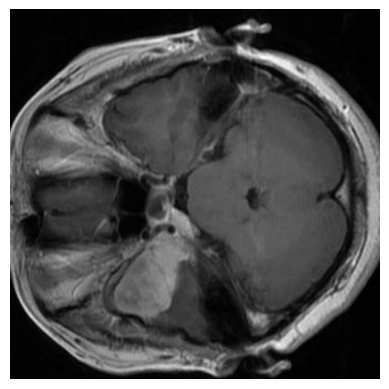

1 0.49860724218749997 0.6100278546875 0.48189415 0.5626740953125 0.4206128140625 0.5264623953124999 0.4122562671875 0.5459610031250001 0.4206128140625 0.5933147625 0.337047353125 0.6768802234375 0.2841225625 0.7548746515625 0.2841225625 0.79665738125 0.3091922 0.8217270187500001 0.3871866296875 0.8328690812499999 0.42618384374999996 0.8133704734375 0.4568245125 0.6908078 0.49860724218749997 0.6573816156250001 0.49860724218749997 0.6100278546875


In [48]:
# Plot labels in image
image_path = "../data/BrainTumor/train/images/1_jpg.rf.eee6547c09d13001fff4a45c380115aa.jpg"
label_path = "../data/BrainTumor/train/labels/1_jpg.rf.eee6547c09d13001fff4a45c380115aa.txt"

# Load image
with Image.open(image_path) as img:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Load label in yolo format
with open(label_path, "r") as f:
    label = f.read()

# # Plot label in image
# for line in label.splitlines():
#     class_id, x_center, y_center, width, height = map(float, line.split())
#     # Convert YOLO format to pixel coordinates
#     x1 = (x_center - width / 2) * img.width
#     y1 = (y_center - height / 2) * img.height
#     x2 = (x_center + width / 2) * img.width
#     y2 = (y_center + height / 2) * img.height
#     plt.rectangle((x1, y1), (x2, y2), outline="red", width=2)

print(label)

## Model Summary:

In [2]:
# Load Dinov2 Model and transformer
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base", use_fast=True)
dinov2 = AutoModel.from_pretrained("facebook/dinov2-base")

torchinfo.summary(
    dinov2,
    input_data=torch.randn(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=3,
    row_settings=["var_names"],
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
Dinov2Model (Dinov2Model)                                    [1, 3, 224, 224]          [1, 768]                  --                        True
├─Dinov2Embeddings (embeddings)                              [1, 3, 224, 224]          [1, 257, 768]             1,053,696                 True
│    └─Dinov2PatchEmbeddings (patch_embeddings)              [1, 3, 224, 224]          [1, 256, 768]             --                        True
│    │    └─Conv2d (projection)                              [1, 3, 224, 224]          [1, 768, 16, 16]          452,352                   True
│    └─Dropout (dropout)                                     [1, 257, 768]             [1, 257, 768]             --                        --
├─Dinov2Encoder (encoder)                                    [1, 257, 768]             [1, 257, 768]             --                  

In [44]:
print(processor)

BitImageProcessorFast {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "data_format": "channels_first",
  "default_to_square": false,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "shortest_edge": 256
  }
}



## Feature Extraction Visualization:

In [ ]:
# Set random seed
random.seed(5)

# Number of images to select
num_images = 6

# Get n random image paths
img_dir = "../data/BrainTumor/train/images"
img_paths = glob(os.path.join(img_dir, "*.jpg"))
selected_imgs = random.sample(img_paths, num_images)

# Load images
images = [Image.open(p) for p in selected_imgs]

# Preprocess images
inputs = processor(images=images, return_tensors="pt")

# Extract patch embeddings for all images
dinov2.eval()
with torch.no_grad():
    outputs = dinov2(**inputs)
    feature_maps = outputs.last_hidden_state[:, 1:, :]

# Stack all patches from all images
batch_size, num_patches, embed_dim = feature_maps.shape
all_patches = feature_maps.reshape(-1, embed_dim)

print(f"Feature maps shape: {feature_maps.shape} [batch_size, num_patches, embed_dim]")
print(f"All patches shape: {all_patches.shape} [batch_size*num_patches, embed_dim]")

Feature maps shape: torch.Size([6, 256, 768]) [batch, num_patches, embed_dim]
All patches shape: torch.Size([1536, 768]) [batch*num_patches, embed_dim]


PCA explained variance ratio: [0.1157739  0.08909586 0.08645522]
Total variance explained: 0.291


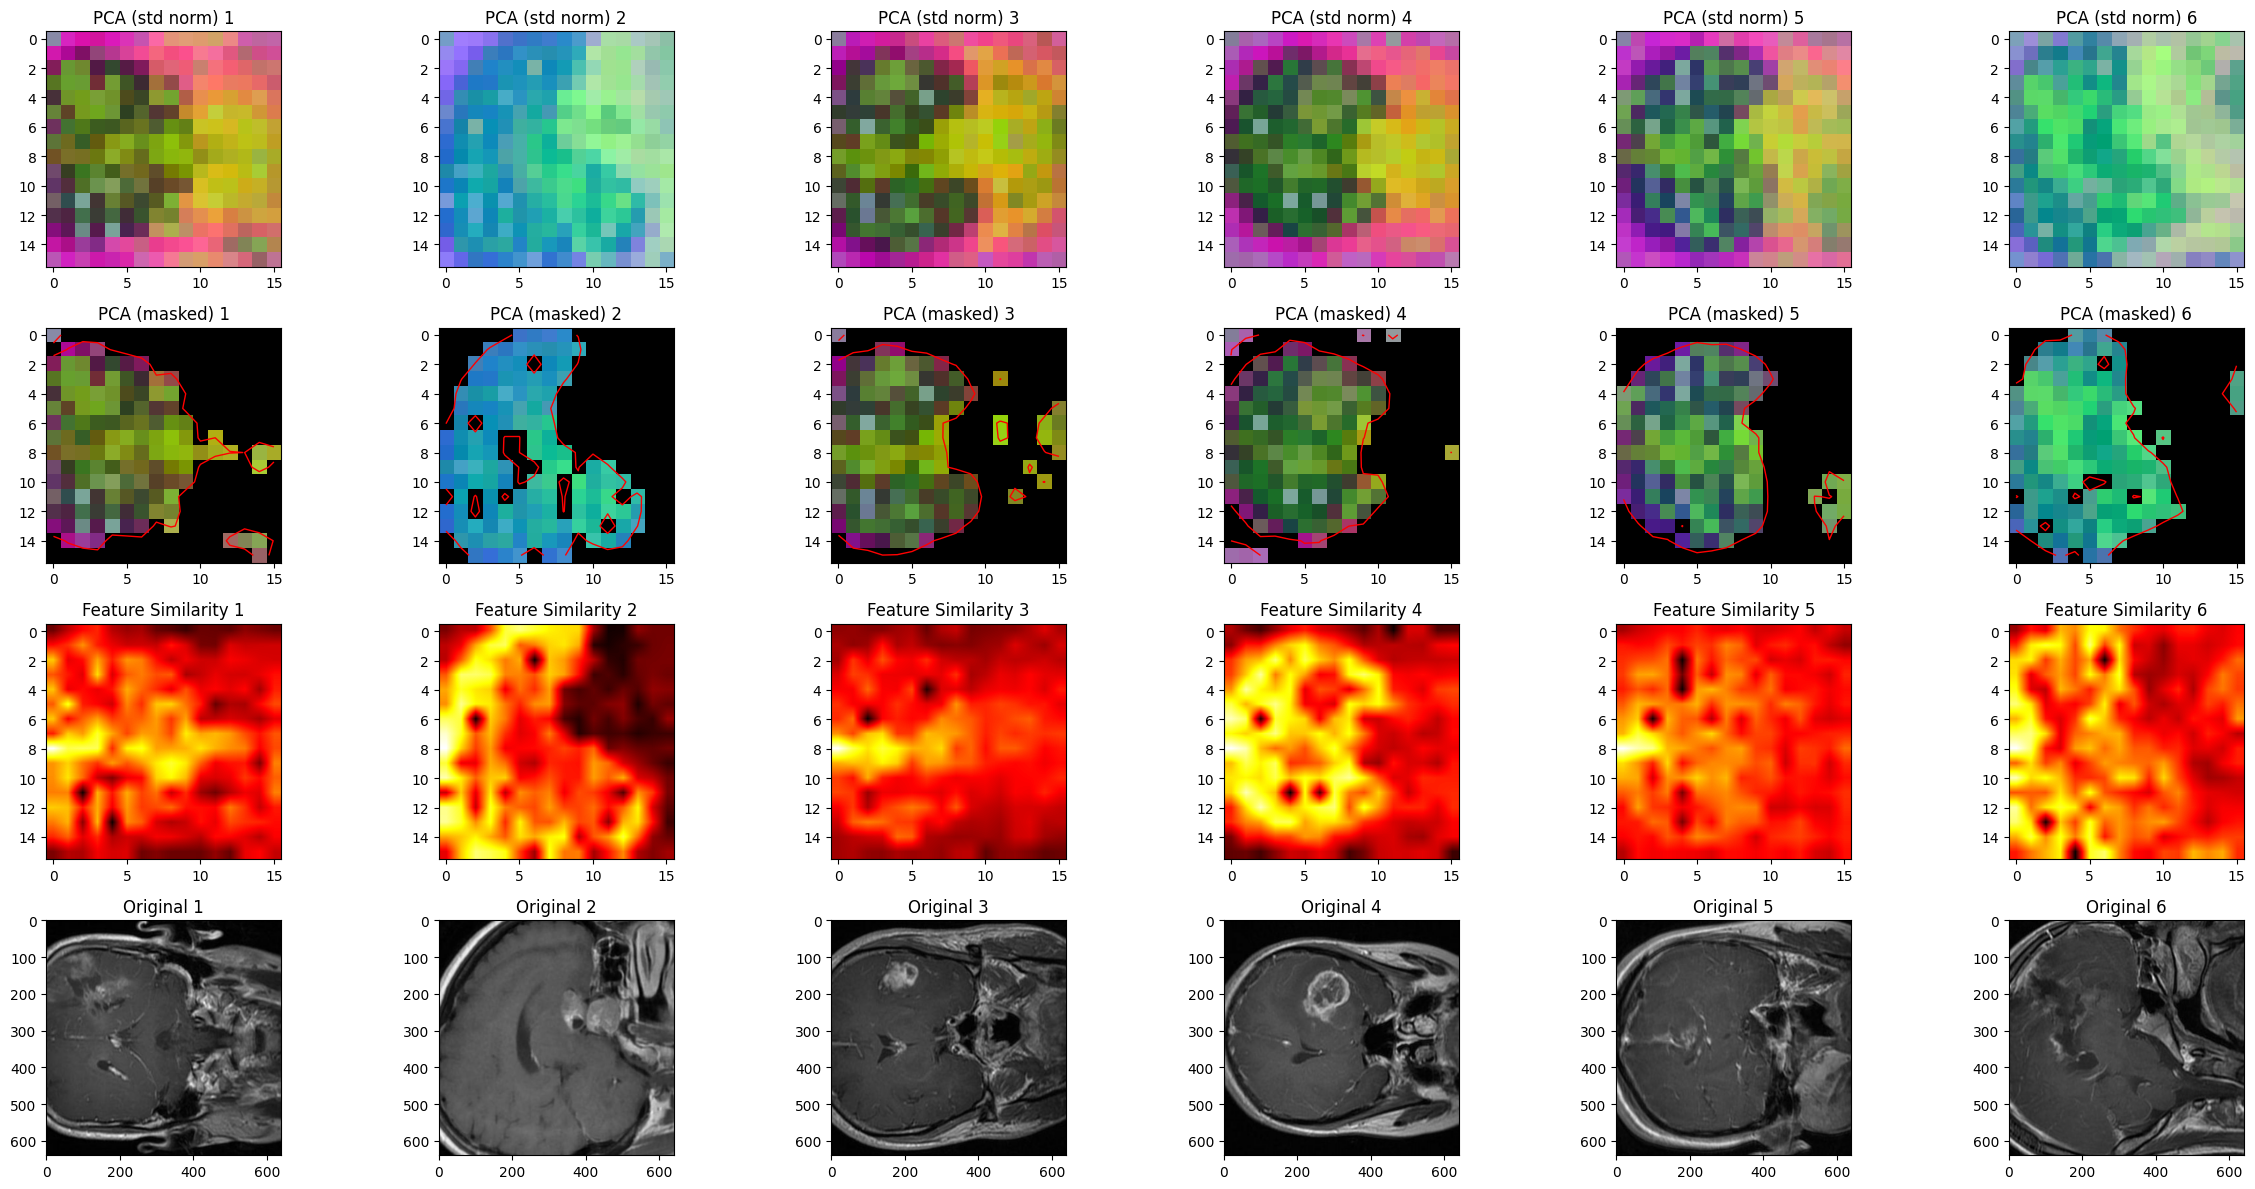

In [13]:
# Apply PCA to all patches
pca = decomposition.PCA(n_components=3)
all_pca = pca.fit_transform(all_patches)

# Improved PCA Visualization
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# Alternative normalization: per-component standardization
all_pca_std = (all_pca - all_pca.mean(0)) / (all_pca.std(0) + 1e-8)
all_pca_std_norm = (all_pca_std - all_pca_std.min(0)) / (np.ptp(all_pca_std, axis=0) + 1e-8)

# Split back to images with improved normalization
num_patches_side = int(np.sqrt(num_patches))
pca_imgs_std = all_pca_std_norm.reshape(batch_size, num_patches, 3)
pca_imgs_std = pca_imgs_std.reshape(batch_size, num_patches_side, num_patches_side, 3)

# Apply adaptive background masking based on the first principal component
fig, axs = plt.subplots(4, batch_size, figsize=(4 * batch_size, 12))

for i in range(batch_size):
    # Compute adaptive threshold for background masking
    first_pc = pca_imgs_std[i][..., 0]
    threshold = np.percentile(first_pc, 50)  # Use 50th percentile as threshold

    # Apply background mask
    background_mask = first_pc > threshold
    pca_img_masked = pca_imgs_std[i].copy()
    pca_img_masked[background_mask] = 0

    # Compute cosine similarity between patch features
    patches = feature_maps[i]  # [num_patches, embed_dim]
    patches_norm = torch.nn.functional.normalize(patches, p=2, dim=1)
    similarity_matrix = torch.mm(patches_norm, patches_norm.T)

    # Use center patch as reference
    center_idx = similarity_matrix.shape[0] // 2
    center_similarities = similarity_matrix[center_idx, :]
    similarity_map = center_similarities.reshape(num_patches_side, num_patches_side)

    # Original PCA (no masking)
    axs[0, i].imshow(pca_imgs_std[i])
    axs[0, i].set_title(f"PCA (std norm) {i + 1}")

    # PCA with adaptive background masking
    axs[1, i].imshow(pca_img_masked)
    axs[1, i].set_title(f"PCA (masked) {i + 1}")
    axs[1, i].contour(first_pc, levels=[threshold], colors="red", linewidths=1)

    # Feature similarity
    axs[2, i].imshow(similarity_map.cpu().numpy(), cmap="hot", interpolation="bilinear")
    axs[2, i].set_title(f"Feature Similarity {i + 1}")

    # Original image
    axs[3, i].imshow(images[i])
    axs[3, i].set_title(f"Original {i + 1}")

plt.tight_layout()
plt.show()

## Set up dataset

In [ ]:
# Object Detection Dataset and DataLoader
class YOLODataset(Dataset):
    """Simplified Dataset for YOLO format object detection"""

    def __init__(self, images_dir: Path, labels_dir: Path, processor=None) -> None:
        """
        Args:
            images_dir: Path to images folder
            labels_dir: Path to labels folder
            processor: Image processor (DINOv2 processor)
        """
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.processor = processor

        # Get all image files
        self.image_files = list(self.images_dir.glob("*.jpg")) + list(self.images_dir.glob("*.png"))
        self.image_files.sort()

        print(f"Found {len(self.image_files)} images in {images_dir}")

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx) -> Dict[str, Any]:
        # Load image
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        # Load YOLO labels
        label_path = self.labels_dir / f"{img_path.stem}.txt"
        labels = self._load_yolo_labels(label_path, image.size)

        # Process image
        if self.processor:
            processed_image = self.processor(images=image, return_tensors="pt")
            pixel_values = processed_image["pixel_values"].squeeze(0)
        else:
            pixel_values = image

        return {"pixel_values": pixel_values, "labels": labels, "image_path": str(img_path), "original_image": image}

    def _load_yolo_labels(self, label_path: Path, image_size: Tuple[int, int]) -> List[Dict]:
        """Load YOLO format labels (class x_center y_center width height)"""
        labels = []
        img_width, img_height = image_size

        if not label_path.exists():
            return labels

        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * img_width
                    y_center = float(parts[2]) * img_height
                    width = float(parts[3]) * img_width
                    height = float(parts[4]) * img_height

                    # Convert to x_min, y_min, x_max, y_max
                    x_min = x_center - width / 2
                    y_min = y_center - height / 2
                    x_max = x_center + width / 2
                    y_max = y_center + height / 2

                    labels.append({"class_id": class_id, "bbox": [x_min, y_min, x_max, y_max], "area": width * height})

        return labels


def create_dataloaders(
    train_images_dir: Path,
    train_labels_dir: Path,
    test_images_dir: Path,
    test_labels_dir: Path,
    processor,
    batch_size: int = 32,
) -> Tuple[DataLoader, DataLoader]:
    """Create DataLoaders for YOLO dataset"""

    # Create datasets
    train_dataset = YOLODataset(train_images_dir, train_labels_dir, processor)
    test_dataset = YOLODataset(test_images_dir, test_labels_dir, processor)

    def collate_fn(batch):
        """Custom collate function to handle variable number of labels"""
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        labels = [item["labels"] for item in batch]
        image_paths = [item["image_path"] for item in batch]
        original_images = [item["original_image"] for item in batch]

        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "image_paths": image_paths,
            "original_images": original_images,
        }

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_dataloader, test_dataloader

In [21]:
# Create your YOLO dataloaders
train_images_dir = Path("../data/BrainTumor/train/images")
train_labels_dir = Path("../data/BrainTumor/train/labels")
test_images_dir = Path("../data/BrainTumor/test/images")
test_labels_dir = Path("../data/BrainTumor/test/labels")

train_dataloader_det, test_dataloader_det = create_dataloaders(
    train_images_dir=train_images_dir,
    train_labels_dir=train_labels_dir,
    test_images_dir=test_images_dir,
    test_labels_dir=test_labels_dir,
    processor=processor,
    batch_size=32,  # Smaller batch size for object detection
)

print(f"Train dataloader: {len(train_dataloader_det)} batches")
print(f"Test dataloader: {len(test_dataloader_det)} batches")


Found 2144 images in ../data/BrainTumor/train/images
Found 308 images in ../data/BrainTumor/test/images
Train dataloader: 67 batches
Test dataloader: 10 batches


In [28]:
train_dataloader_det.dataset[0]

{'pixel_values': tensor([[[-2.0152, -2.0152, -2.0152,  ..., -1.8782, -1.8953, -1.9124],
          [-1.9980, -1.9980, -1.9980,  ..., -1.9809, -1.9124, -1.8782],
          [-1.9809, -1.9809, -1.9809,  ..., -2.0152, -1.9467, -1.8953],
          ...,
          [-2.0152, -2.0152, -2.0152,  ...,  0.0569,  0.0741, -0.3712],
          [-1.9809, -2.0152, -2.0323,  ..., -0.3712, -0.4054, -0.5596],
          [-2.0323, -2.0152, -1.9980,  ..., -0.5596, -0.5596, -0.7137]],
 
         [[-1.9307, -1.9307, -1.9307,  ..., -1.7906, -1.8081, -1.8256],
          [-1.9132, -1.9132, -1.9132,  ..., -1.8957, -1.8256, -1.7906],
          [-1.8957, -1.8957, -1.8957,  ..., -1.9307, -1.8606, -1.8081],
          ...,
          [-1.9307, -1.9307, -1.9307,  ...,  0.1877,  0.2052, -0.2500],
          [-1.8957, -1.9307, -1.9482,  ..., -0.2500, -0.2850, -0.4426],
          [-1.9482, -1.9307, -1.9132,  ..., -0.4426, -0.4426, -0.6001]],
 
         [[-1.6999, -1.6999, -1.6999,  ..., -1.5604, -1.5779, -1.5953],
          [-

Testing YOLO DataLoader...
Batch shape: torch.Size([32, 3, 224, 224])
Number of images with labels: 32
Batch shape: torch.Size([32, 3, 224, 224])
Number of images with labels: 32


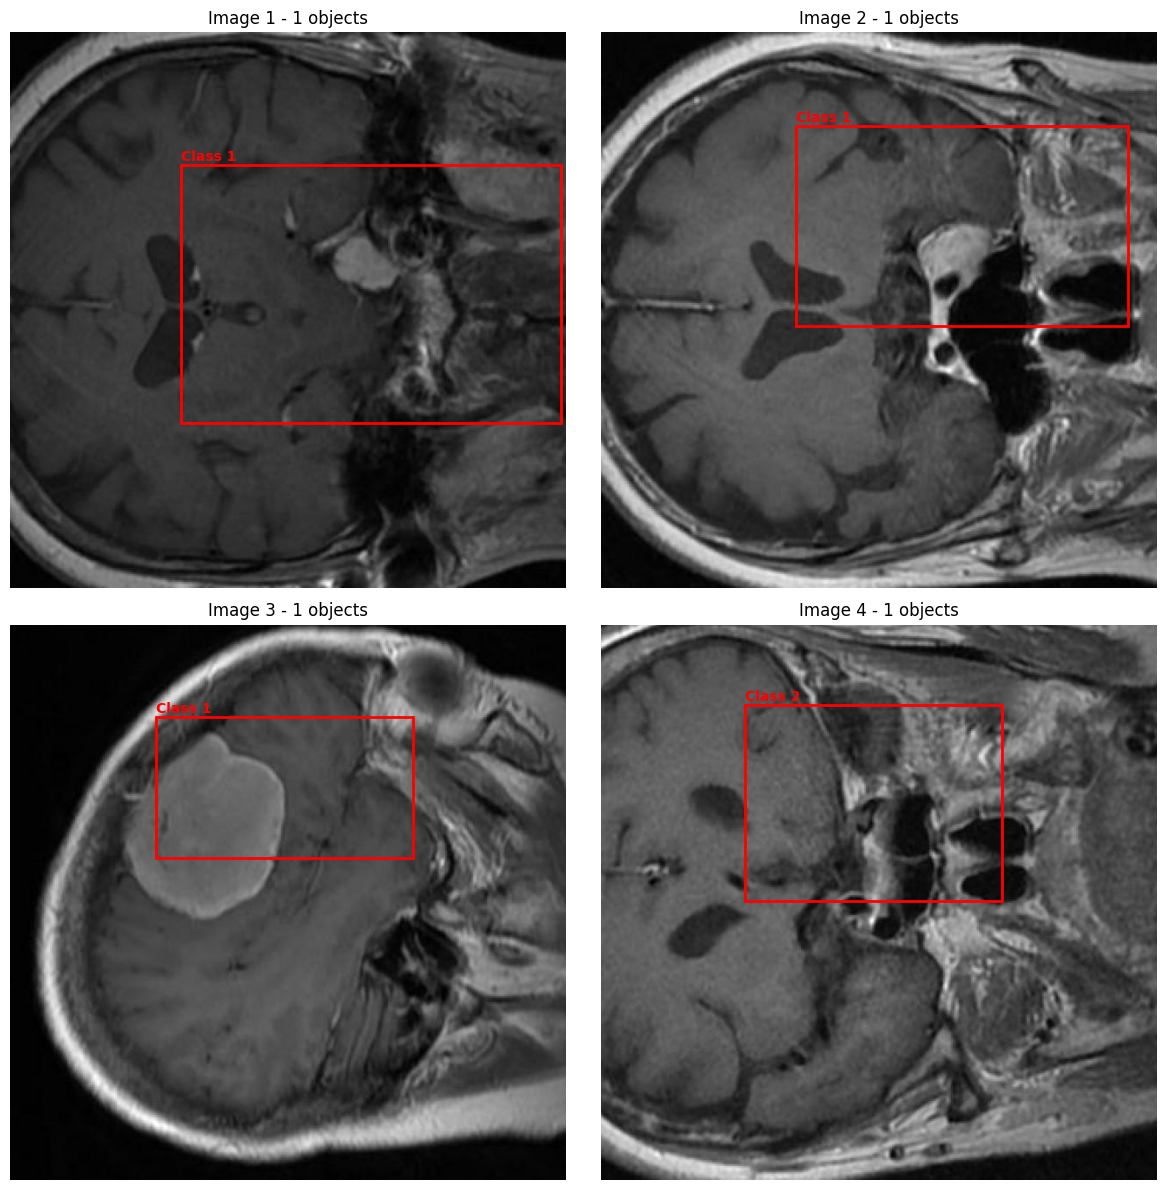

\nDataset Statistics:
Total training images: 2144
Total objects: 2144
Average objects per image: 1.00
Class distribution: {1: 503, 0: 983, 2: 658}
\nSample data structure:
Keys: dict_keys(['pixel_values', 'labels', 'image_paths', 'original_images'])
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels for first image: [{'class_id': 1, 'bbox': [147.07520849999997, 122.11699150000001, 487.5766015, 426.96378849999996], 'area': 103800.75903008821}]
Total training images: 2144
Total objects: 2144
Average objects per image: 1.00
Class distribution: {1: 503, 0: 983, 2: 658}
\nSample data structure:
Keys: dict_keys(['pixel_values', 'labels', 'image_paths', 'original_images'])
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels for first image: [{'class_id': 1, 'bbox': [147.07520849999997, 122.11699150000001, 487.5766015, 426.96378849999996], 'area': 103800.75903008821}]


In [25]:
# Test the YOLO DataLoader and Visualize Samples
import matplotlib.patches as patches


def visualize_yolo_batch(dataloader, num_samples=4):
    """Visualize a batch of images with YOLO bounding boxes"""

    # Get one batch
    batch = next(iter(dataloader))

    pixel_values = batch["pixel_values"]
    labels_list = batch["labels"]
    original_images = batch["original_images"]

    print(f"Batch shape: {pixel_values.shape}")
    print(f"Number of images with labels: {sum(1 for labels in labels_list if len(labels) > 0)}")

    # Plot images with bounding boxes
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(min(num_samples, len(original_images))):
        ax = axes[i]
        image = original_images[i]
        labels = labels_list[i]

        # Display image
        ax.imshow(image)
        ax.set_title(f"Image {i + 1} - {len(labels)} objects")
        ax.axis("off")

        # Draw bounding boxes
        for label in labels:
            bbox = label["bbox"]  # [x_min, y_min, x_max, y_max]
            class_id = label["class_id"]

            # Create rectangle patch
            x_min, y_min, x_max, y_max = bbox
            width = x_max - x_min
            height = y_max - y_min

            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)

            # Add class label
            ax.text(x_min, y_min - 5, f"Class {class_id}", color="red", fontsize=10, fontweight="bold")

    plt.tight_layout()
    plt.show()


# Test the dataloader
print("Testing YOLO DataLoader...")
visualize_yolo_batch(train_dataloader_det, num_samples=4)

# Print some statistics
print("\\nDataset Statistics:")
total_images = 0
total_objects = 0
class_counts = {}

for batch in train_dataloader_det:
    labels_list = batch["labels"]
    total_images += len(labels_list)

    for labels in labels_list:
        total_objects += len(labels)
        for label in labels:
            class_id = label["class_id"]
            class_counts[class_id] = class_counts.get(class_id, 0) + 1

print(f"Total training images: {total_images}")
print(f"Total objects: {total_objects}")
print(f"Average objects per image: {total_objects / total_images:.2f}")
print(f"Class distribution: {class_counts}")

# Test a single sample to see the data structure
print("\\nSample data structure:")
sample = next(iter(train_dataloader_det))
print(f"Keys: {sample.keys()}")
print(f"Pixel values shape: {sample['pixel_values'].shape}")
print(f"Labels for first image: {sample['labels'][0]}")